# Analyze articles from mega journals

## Prerequirements


In [1]:
!pip install crossrefapi
!pip install wordcloud

*Note:* After installing the package the first time, you need to restart the kernel in this Jupyter Notebook, or close and open the notebook itself.

In [1]:
# You can change this to one of the values:
choice = "academia-letters"
#choice = "plos-one"
#choice = "peerj"
#choice = "peerj-cs"
#choice = "sage-open"
#choice = "open-research-europe"
#choice = "f1000-research"

prefix = choice + "-"

## Step 1: Gather the data for all articles

In [3]:
from crossref.restful import Works, Journals

works = Works()
journals = Journals()

if choice == "academia-letters": articles = works.filter(container_title="Academia Letters")
if choice == "plos-one": articles = journals.works('1932-6203').filter(from_issued_date='2021')
if choice == "peerj": articles = journals.works('2167-8359').filter(from_issued_date='2021')
if choice == "peerj-cs": articles = journals.works('2376-5992').filter(from_issued_date='2021')
if choice == "sage-open": articles = journals.works('2158-2440').filter(from_issued_date='2021')
if choice == "open-research-europe": articles = journals.works('2732-5121').filter(from_issued_date='2021')
if choice == "f1000-research": articles = journals.works('2046-1402').filter(from_issued_date='2021')

print(articles.count(), articles.url)

3895 https://api.crossref.org/works?filter=container-title%3AAcademia+Letters


## Step 2: Save data in CSV files

In [4]:
import csv

In [5]:
def parse(key, obj):
    if key in obj:
        value = obj[key]
    else:
        return ''

    if key in ['issued', 'published', 'published-online', 'indexed', 'created']:
        # e.g. {"date-parts":[[2021,8,17]],"date-time":"2021-08-17T20:02:44Z","timestamp":1629230564000}
        if "date-parts" in value:
            return ", ".join(["-".join(map(str, date)) for date in value['date-parts']])
        else:
            print("WARNING: unexpected date format", value)

    if key in ['title', 'container-title']:
        if len(value) == 1:
            return(value[0])
        else:
            print("WARNING: unexpected title format", value)

    # ISSN is an array and we simply concatenate multiple values
    if key in ['ISSN']:
        return ", ".join(value)
    if key in ['affiliation']:
        return " + ".join([aff['name'] for aff in value])

    return value

In [6]:
fields = ['DOI', 'prefix', 'title', 'language', 'container-title', 'ISSN', 'publisher', 'URL', 'issued', 'published', 'published-online', 'indexed', 'created', 'reference-count', 'is-referenced-by-count', 'type', 'member']
with open(prefix + 'papers.csv', 'w', newline='') as papersfile:
    paperswriter = csv.writer(papersfile)
    paperswriter.writerow(fields)

    author_fields = ['given', 'family', 'sequence', 'affiliation']
    with open(prefix + 'authors.csv', 'w', newline='') as authorsfile:
        authorswriter = csv.writer(authorsfile)
        authorswriter.writerow(author_fields + ['DOI'])

        i=0
        for entry in articles:
            i += 1
            line = [parse(field, entry) for field in fields]
            paperswriter.writerow(line)

            if 'author' in entry:
                for author in entry['author']:
                    author_line = [parse(field, author) for field in author_fields]
                    author_line.append(entry['DOI'])
                    authorswriter.writerow(author_line)
            else:
                print("WARNING: no author info for", entry['DOI'], entry['title'])

            # For testing
            #if i > 3: break


## Step 3: Analyze the papers

This step only needs the previously created csv file.

In [4]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# reading csv file as pandas dataframe
data = pd.read_csv(prefix + 'papers.csv')

data['issued'] = pd.to_datetime(data['issued'])
data['year'] = data['issued'].dt.year
data['month'] = data['issued'].dt.month
data['weekday'] = data['issued'].dt.weekday

data.head()

,DOI,prefix,title,language,container-title,ISSN,publisher,URL,issued,published,published-online,indexed,created,reference-count,is-referenced-by-count,type,member,year,month,weekday
0,10.20935/al2610,10.20935,Florentino Ariza as a Machiavellian artist in ...,en,Academia Letters,NaN,Academia.edu,http://dx.doi.org/10.20935/al2610,2021-08-04,2021-8-4,2021-8-4,2021-12-8,2021-8-17,0,0,journal-article,9563,2021,8,2
1,10.20935/al953,10.20935,A Novel Treatment Approach in Alzheimer’s Dise...,en,Academia Letters,NaN,Academia.edu,http://dx.doi.org/10.20935/al953,2021-04-28,2021-4-28,2021-4-28,2021-12-12,2021-4-28,0,0,journal-article,9563,2021,4,2
2,10.20935/al106,10.20935,Designing optimal welfare policies for interme...,en,Academia Letters,2771-9359,Academia.edu,http://dx.doi.org/10.20935/al106,2020-12-29,2020-12-29,2020-12-29,2022-3-13,2021-1-14,0,1,journal-article,9563,2020,12,1
3,10.20935/al421,10.20935,Back and Forth: The Journey of Inclusive Educa...,en,Academia Letters,NaN,Academia.edu,http://dx.doi.org/10.20935/al421,2021-03-04,2021-3-4,2021-3-4,2021-12-18,2021-3-6,0,0,journal-article,9563,2021,3,3
4,10.20935/al3740,10.20935,A Proof of Concept Randomized Controlled Trial...,en,Academia Letters,NaN,Academia.edu,http://dx.doi.org/10.20935/al3740,2021-10-20,2021-10-20,2021-10-20,2021-12-9,2021-11-11,0,0,journal-article,9563,2021,10,2


In [8]:
print(data['prefix'].value_counts(), "\n")
print(data['language'].value_counts(), "\n")
print(data['container-title'].value_counts(), "\n")
print(data['ISSN'].value_counts(), "\n")
print(data['publisher'].value_counts(), "\n")
print(data['type'].value_counts(), "\n")
print(data['member'].value_counts(), "\n")

10.20935    3895
Name: prefix, dtype: int64 

en    3895
Name: language, dtype: int64 

Academia Letters    3895
Name: container-title, dtype: int64 

2771-9359    3839
Name: ISSN, dtype: int64 

Academia.edu    3895
Name: publisher, dtype: int64 

journal-article    3895
Name: type, dtype: int64 

9563    3895
Name: member, dtype: int64 



0    0.976380
1    0.020026
2    0.002824
3    0.000257
4    0.000257
6    0.000257
Name: is-referenced-by-count, dtype: float64


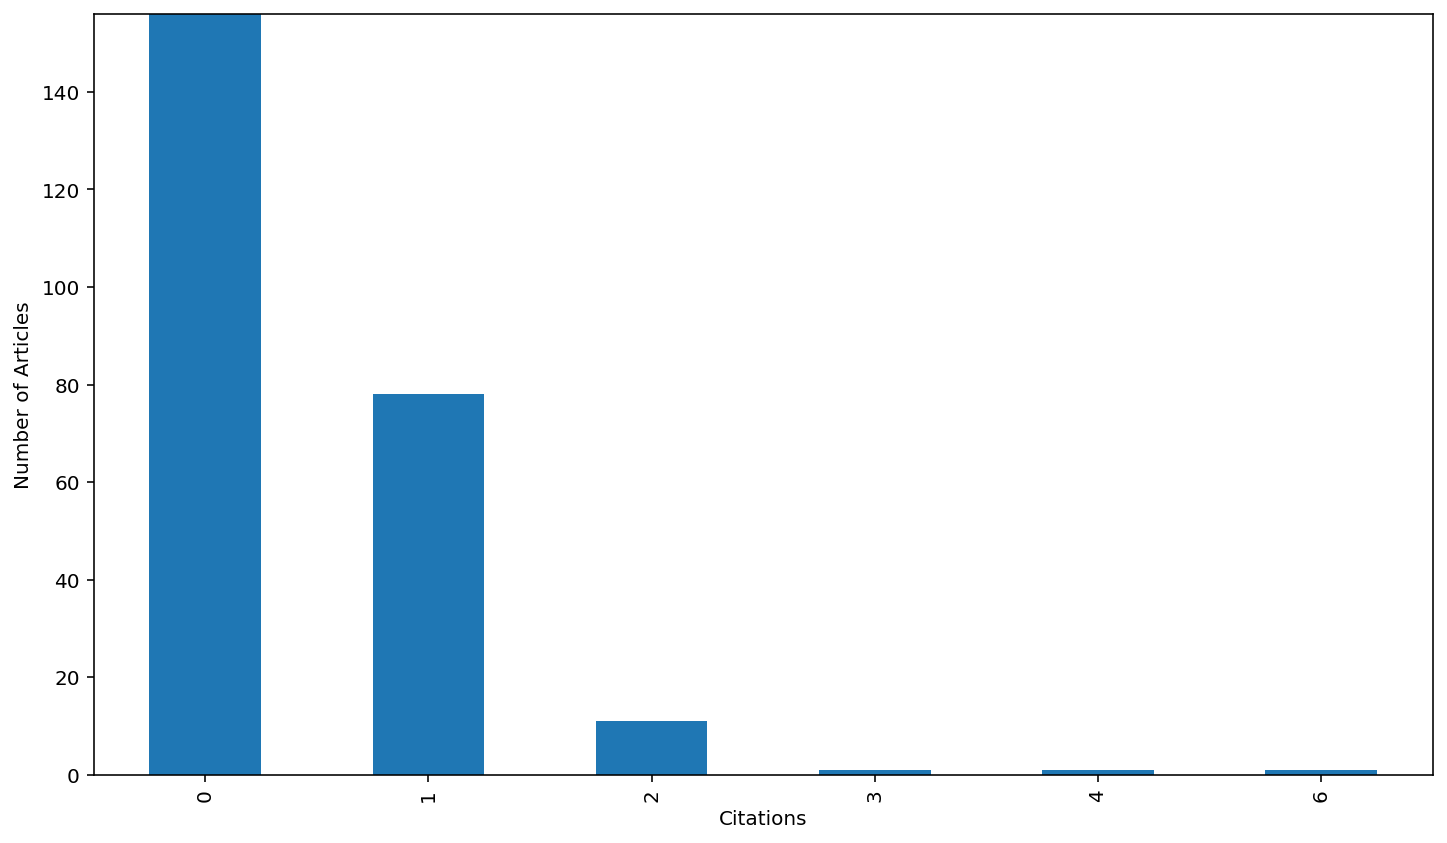

In [9]:
# print(data['reference-count'].value_counts())
citations = data['is-referenced-by-count'].value_counts().sort_index()
print(data['is-referenced-by-count'].value_counts(normalize=True).sort_index())

citations.plot(kind='bar')
hmax = max(data['is-referenced-by-count'].value_counts()[1:])*2
plt.axis(ymax=hmax)
plt.xlabel("Citations")
plt.ylabel("Number of Articles")
#plt.bar_label()
plt.savefig(prefix + 'citations-distribution.png')

In [10]:
print(data['issued'].value_counts())

2021-03-20    153
2021-07-14    152
2021-07-15    131
2021-07-13    124
2021-04-12     84
             ... 
2021-05-04      1
2020-12-09      1
2021-02-08      1
2021-11-28      1
2020-09-23      1
Name: issued, Length: 246, dtype: int64


In [11]:
data[(data['year'] == 2021) & (data['month'] == 7)]['issued'].value_counts()

2021-07-14    152
2021-07-15    131
2021-07-13    124
2021-07-16     81
2021-07-25     65
2021-07-12     64
2021-07-02     55
2021-07-01     48
2021-07-27     36
2021-07-08     34
2021-07-07     31
2021-07-28     30
2021-07-29     23
2021-07-19     17
2021-07-17     16
2021-07-20     16
2021-07-21     11
2021-07-30     10
2021-07-26      5
2021-07-22      3
2021-07-09      1
Name: issued, dtype: int64

In [12]:
# The top three are more than 500 articles published within 3 days??

In [13]:
data['weekday'].value_counts().sort_index()

0    644
1    553
2    809
3    760
4    493
5    374
6    262
Name: weekday, dtype: int64

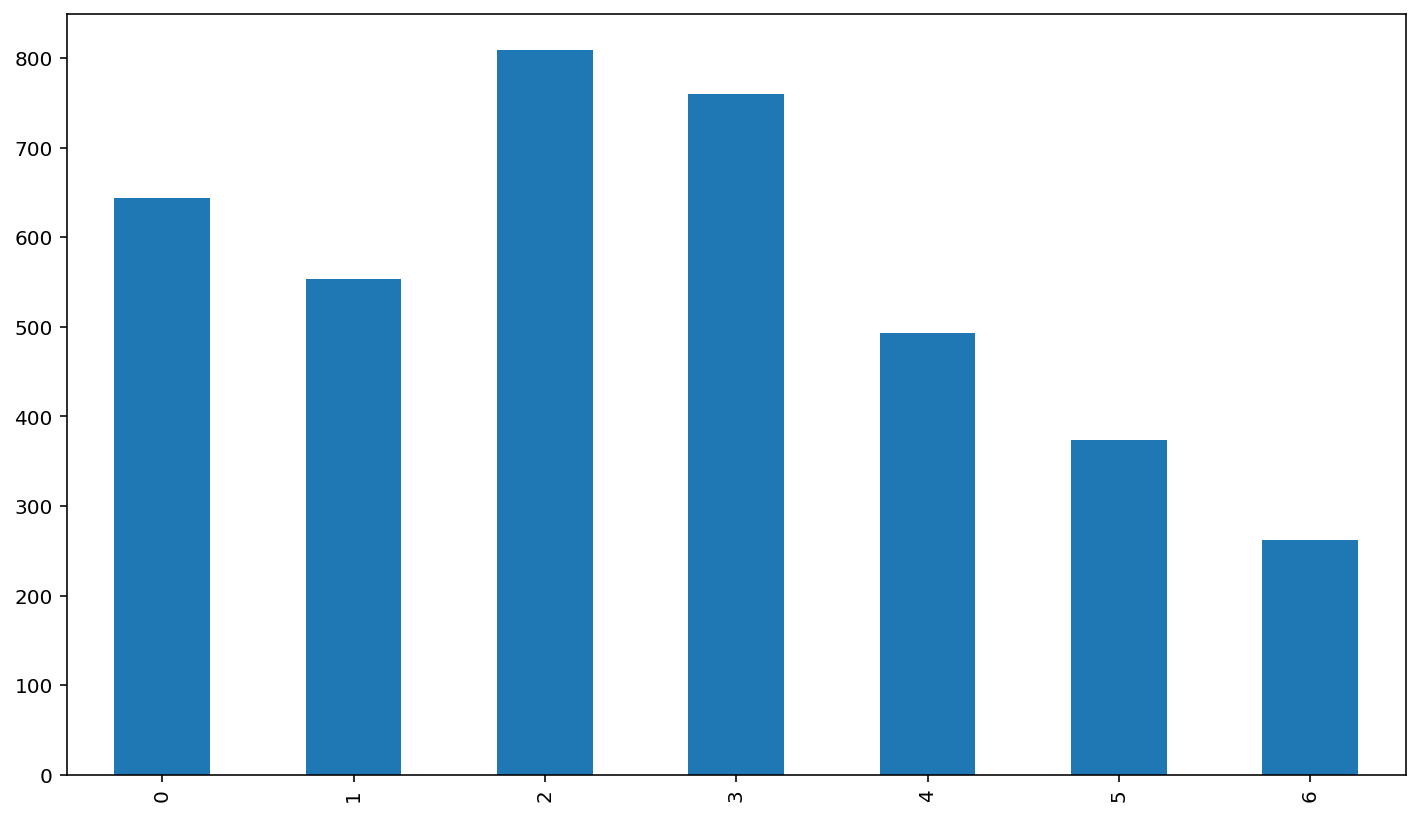

In [14]:
fig = plt.figure()
data['weekday'].value_counts().sort_index().plot(kind='bar')
plt.savefig(prefix + 'publicatins-weekday.png')

In [15]:
# Articles appear on all days of the week also on sunday (6)??

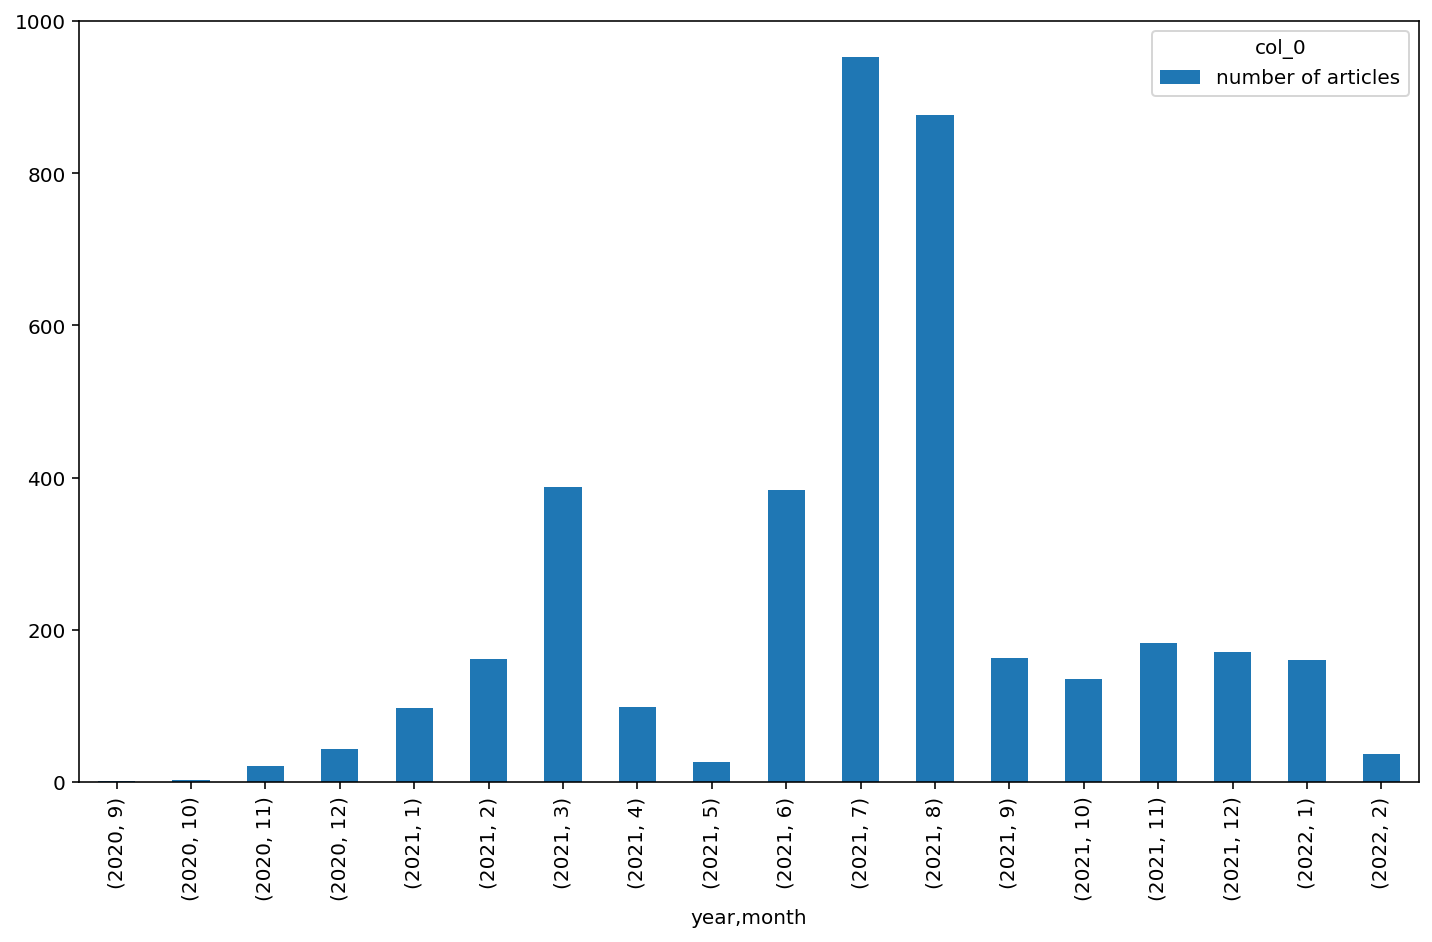

In [16]:
freq_table = pd.crosstab([data['year'], data['month']], 'number of articles')
freq_table.plot(kind='bar')
plt.savefig(prefix + 'published-articles.png')

In [5]:
wordsFromTitles = ""
with open(prefix + 'papers.csv', 'r', newline='') as papersfile:
    reader = csv.DictReader(papersfile)
    for row in reader:
        wordsFromTitles += row['title'] + " | "

# print(wordsFromTitles)

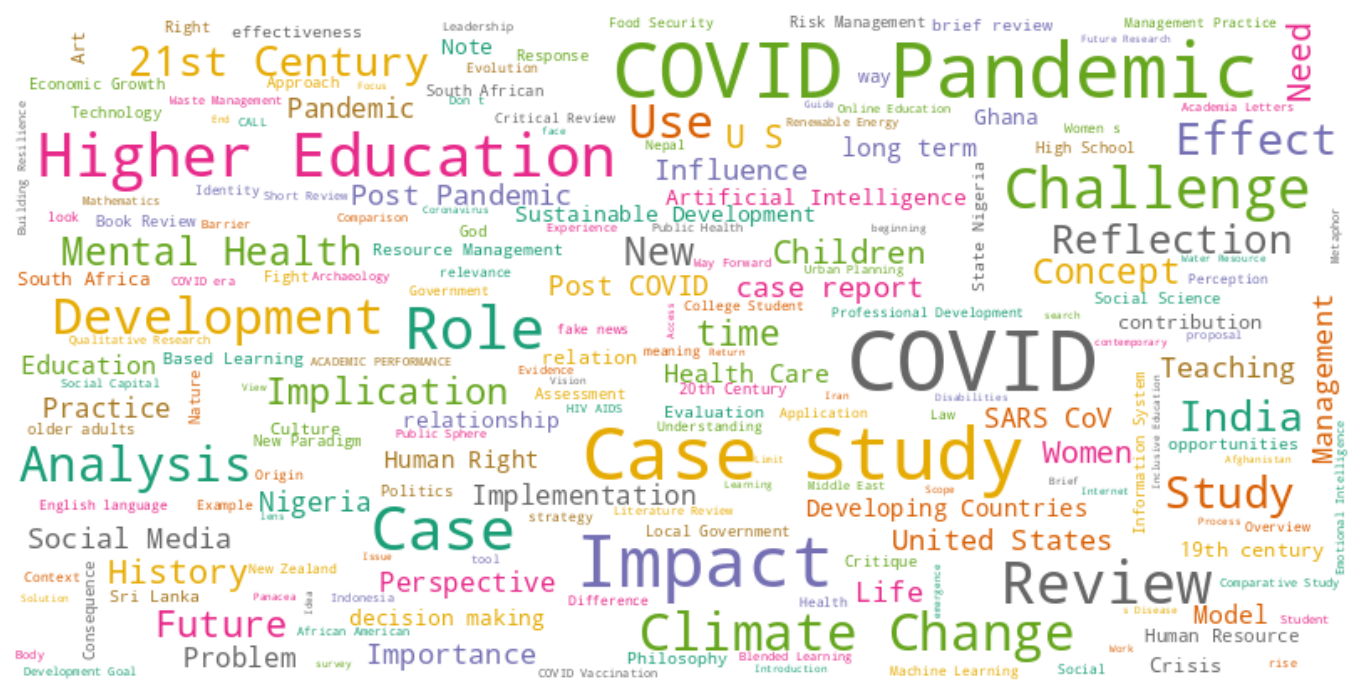

In [7]:
from wordcloud import WordCloud
#wordcloud = WordCloud().generate(wordsFromTitles)

wordcloud = WordCloud(max_font_size=50, collocation_threshold=5, background_color="white", colormap="Dark2", width=800, height=400).generate(wordsFromTitles)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.savefig(prefix + 'wordcloud.png')
plt.show()

## Step 4: Analyze authors and affiliations

In [19]:
# reading csv file as pandas dataframe
authors_data = pd.read_csv(prefix + 'authors.csv')
authors_data['full-name'] = authors_data['given'] + " " + authors_data['family']

data.head()

,DOI,prefix,title,language,container-title,ISSN,publisher,URL,issued,published,published-online,indexed,created,reference-count,is-referenced-by-count,type,member,year,month,weekday
0,10.20935/al2610,10.20935,Florentino Ariza as a Machiavellian artist in ...,en,Academia Letters,NaN,Academia.edu,http://dx.doi.org/10.20935/al2610,2021-08-04,2021-8-4,2021-8-4,2021-12-8,2021-8-17,0,0,journal-article,9563,2021,8,2
1,10.20935/al953,10.20935,A Novel Treatment Approach in Alzheimer’s Dise...,en,Academia Letters,NaN,Academia.edu,http://dx.doi.org/10.20935/al953,2021-04-28,2021-4-28,2021-4-28,2021-12-12,2021-4-28,0,0,journal-article,9563,2021,4,2
2,10.20935/al106,10.20935,Designing optimal welfare policies for interme...,en,Academia Letters,2771-9359,Academia.edu,http://dx.doi.org/10.20935/al106,2020-12-29,2020-12-29,2020-12-29,2022-3-13,2021-1-14,0,1,journal-article,9563,2020,12,1
3,10.20935/al421,10.20935,Back and Forth: The Journey of Inclusive Educa...,en,Academia Letters,NaN,Academia.edu,http://dx.doi.org/10.20935/al421,2021-03-04,2021-3-4,2021-3-4,2021-12-18,2021-3-6,0,0,journal-article,9563,2021,3,3
4,10.20935/al3740,10.20935,A Proof of Concept Randomized Controlled Trial...,en,Academia Letters,NaN,Academia.edu,http://dx.doi.org/10.20935/al3740,2021-10-20,2021-10-20,2021-10-20,2021-12-9,2021-11-11,0,0,journal-article,9563,2021,10,2


In [20]:
authors_data['full-name'].value_counts()

Amer Hamad Issa Abukhalaf    14
Kurniawan Arif Maspul        13
Austin Mardon                12
Peter Anto Johnson            9
John Christy Johnson          8
                             ..
Edson Pedro Ferlin            1
Nitza Keren                   1
Qudama Al-Yasiri              1
Gábor Géczi                   1
Aminu Zubairu Surajo          1
Name: full-name, Length: 4843, dtype: int64

In [21]:
authors_data['affiliation'].value_counts()

University of Alberta                                      25
Antarctic Institute of Canada                              14
International Open University                              13
University of Toronto                                      11
Independent researcher                                      9
                                                           ..
Geologist and Paleontologist                                1
CirroLytix Research Services                                1
University of Asia and the Pacific                          1
National School of Political and Administrative Studies     1
International Islamic University Malaysia                   1
Name: affiliation, Length: 2212, dtype: int64

In [22]:
affiliation_data = authors_data.dropna()

In [23]:
affiliation_data[affiliation_data['affiliation'].str.contains('Mannheim')]

,given,family,sequence,affiliation,DOI,full-name
